### Fairness

In [25]:
import numpy as np
import pandas as pd
import optuna

np.random.seed(0)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [26]:
# Fetch loan approval data (synthesized)
url = (
    "https://drive.google.com/file/d/1r6gGvL_s313ThGSU7ziZiuYr2G_yijaZ/view?usp=sharing"
)
file_id = url.split("/")[-2]
dataset = pd.read_csv(f"https://drive.google.com/uc?id={file_id}")

In [27]:
sensitive_columns = ["Gender"]
condition_gender = dataset["Gender"] == "Female"

categorical_features = [
    "Married",
    "Dependents",
    "Education",
    "Self_Employed",
    "Property_Area",
]

dataset["Sensitive_Group"] = np.where(condition_gender, 1, 0)
print(dataset["Sensitive_Group"].mean())

dataset["Loan_Status"] = np.where(dataset["Loan_Status"].isin(["Y"]), 1, 0)

0.1776


In [28]:
display(dataset.groupby("Gender").agg(approval_rate=("Loan_Status", "mean")))

,approval_rate
Gender,
Female,0.640203
Male,0.731494


<code style="font-family: Karma, sans-serif; background:#a7fe01;color:black">We can see that women have a lower approval rate in the training data.</code>


In [29]:
# from https://fairlearn.org/main/auto_examples/plot_credit_loan_decisions.html


def resample_training_data(X, y, A):
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X: The training split of the features
    y: The training split of the target labels
    A: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    common_indices = X.index.intersection(y.index).intersection(A.index)
    X = X.loc[common_indices, :]
    y = y.loc[common_indices]
    A = A.loc[common_indices]

    negative_ids = y[y == 0].index
    positive_ids = y[y == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_resampled = X.loc[balanced_ids, :]
    y_resampled = y.loc[balanced_ids]
    A_resampled = A.loc[balanced_ids]
    return X_resampled, y_resampled, A_resampled

<code style="font-family: Karma, sans-serif; background:#a7fe01;color:black">We resample our data to use a 50% threshold for classifying a label as approved or rejected.</code>


In [30]:
# Load your dataset and preprocess it
X = dataset.drop(["Loan_ID"] + sensitive_columns, axis=1)
y = X.pop("Loan_Status")
A = X.pop("Sensitive_Group")

# Split your data into an initial train and test set
ix_train, ix_test = train_test_split(
    X.index, test_size=0.3, random_state=42, stratify=y
)

print(f"Average approval rate before resampling: {y.mean():.2%}")

# Resample your training data for balancing
X_train, y_train, A_train = resample_training_data(
    X.loc[ix_train], y.loc[ix_train], A.loc[ix_train]
)

# Resample your test data to ensure consistency in rebalancing
X_test, y_test, A_test = resample_training_data(
    X.loc[ix_test], y.loc[ix_test], A.loc[ix_test]
)

# Concatenate the resampled data to have complete X, y, and A
X_b, y_b, A_b = (
    pd.concat([X_train, X_test]),
    pd.concat([y_train, y_test]),
    pd.concat([A_train, A_test]),
)

X_b.reset_index(drop=True, inplace=True)
y_b.reset_index(drop=True, inplace=True)
A_b.reset_index(drop=True, inplace=True)

# Assign indexes on new data
ix_train_b, ix_test_b = y_train.index, y_test.index

print(f"Average approval rate after resampling: {y_b.mean():.2%}")

# Convert categorical features to category data type
for cat in categorical_features:
    X_b[cat] = X_b[cat].astype("category")

Average approval rate before resampling: 70.89%
Average approval rate after resampling: 50.00%


<h4>Fairness Unaware Model</h4>

In [41]:
import numpy as np
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

base_params = {
    "base_score": y_b.loc[ix_train_b].mean(),
    "eval_metric": ["auc"],
    "missing": np.nan,
    "early_stopping_rounds": 10,
    "enable_categorical": True,
    "tree_method": "hist",
    "random_state": 42,
}

n_splits = 10


def objective(trial):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_scores = []

    for train_idx, val_idx in skf.split(X_b.loc[ix_train_b], y_b.loc[ix_train_b]):
        X_train, X_val = (
            X_b.loc[ix_train_b].iloc[train_idx],
            X_b.loc[ix_train_b].iloc[val_idx],
        )
        y_train, y_val = (
            y_b.loc[ix_train_b].iloc[train_idx],
            y_b.loc[ix_train_b].iloc[val_idx],
        )

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 5, 100),
            "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.5, step=0.05),
            "max_depth": trial.suggest_int("max_depth", 1, 15),
            "gamma": trial.suggest_float("gamma", 0, 1, step=0.1),
            "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.05),
            "colsample_bytree": trial.suggest_float(
                "colsample_bytree", 0.5, 1, step=0.01
            ),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
            "alpha": trial.suggest_float("alpha", 0, 30, step=0.005),
            "lambda": trial.suggest_float("lambda", 0, 30, step=0.005),
            "grow_policy": trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            ),
        }

        base_params.update(params)

        xgb_model = XGBClassifier(**base_params)
        xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        y_pred_xgb_train = xgb_model.predict(X_train)
        y_pred_xgb_test = xgb_model.predict(X_val)

        train_score = accuracy_score(y_train, y_pred_xgb_train)
        test_score = accuracy_score(y_val, y_pred_xgb_test)
        
        train_err = 1 - train_score
        test_err = 1 - test_score
        
        score = test_score * abs(train_err/test_err)
        
        accuracy_scores.append(score)

    return np.mean(accuracy_scores)


# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

print("Best Hyperparameters:", best_params)

[I 2023-11-06 21:14:33,514] A new study created in memory with name: no-name-8b1657af-391f-43ed-ac50-0299f7832b87
[I 2023-11-06 21:14:34,539] Trial 0 finished with value: 0.752321181918692 and parameters: {'n_estimators': 67, 'learning_rate': 0.1, 'max_depth': 4, 'gamma': 0.7000000000000001, 'subsample': 0.6, 'colsample_bytree': 0.95, 'min_child_weight': 23, 'alpha': 15.235, 'lambda': 3.96, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.752321181918692.
[I 2023-11-06 21:14:35,073] Trial 1 finished with value: 0.7464887496046787 and parameters: {'n_estimators': 23, 'learning_rate': 0.45000000000000007, 'max_depth': 8, 'gamma': 0.9, 'subsample': 0.55, 'colsample_bytree': 0.55, 'min_child_weight': 39, 'alpha': 8.455, 'lambda': 15.395, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.752321181918692.
[I 2023-11-06 21:14:35,366] Trial 2 finished with value: 0.7321557058896484 and parameters: {'n_estimators': 6, 'learning_rate': 0.2, 'max_depth': 14, 'gamma': 0.2, 'subs

Best Hyperparameters: {'n_estimators': 25, 'learning_rate': 0.5, 'max_depth': 10, 'gamma': 0.4, 'subsample': 1.0, 'colsample_bytree': 0.7, 'min_child_weight': 6, 'alpha': 29.8, 'lambda': 17.635, 'grow_policy': 'lossguide'}


In [32]:
# best_params.update({"enable_categorical": True})
best_params = {
    'n_estimators': 150, 
    'learning_rate': 0.2, 
    'max_depth': 10, 
    'max_leaves': 10, 
    'gamma': 0, 
    'subsample': 0.8, 
    "enable_categorical": True,
    'grow_policy': 'lossguide'
}

xgb_clf = XGBClassifier(**best_params)

xgb_clf.fit(X_b.loc[ix_train_b], y_b.loc[ix_train_b])

predictions_trn = xgb_clf.predict_proba(X_b.loc[ix_train_b])[:, 1]
predictions_tst = xgb_clf.predict_proba(X_b.loc[ix_test_b])[:, 1]

gini_trn = roc_auc_score(y_b.loc[ix_train_b], predictions_trn) * 2 - 1
gini_tst = roc_auc_score(y_b.loc[ix_test_b], predictions_tst) * 2 - 1

print(
    f"Train Gini score: {gini_trn:.2%}\n" 
    f"Test Gini score: {gini_tst:.2%}"
)

Train Gini score: 94.27%
Test Gini score: 85.22%


<h4>ROC Curve</h4>

In [33]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [34]:
label_column = y_b.loc[ix_train_b].copy()
prediction_column = xgb_clf.predict_proba(X_b.loc[ix_train_b])[:, 1]
group_column = A_b.loc[ix_train_b].copy()

roc_data = pd.DataFrame(
    {"label": label_column, "proba": prediction_column, "group": group_column}
)

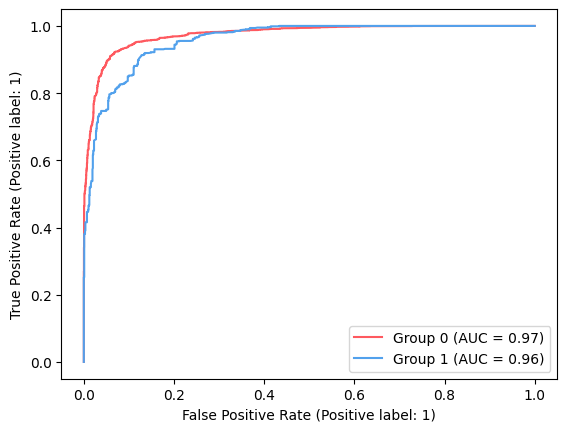

In [35]:
ax_roc_curve = plt.subplot()
colors = ["#fe595f", "#52a1ec"]

for group in [0, 1]:
    roc_group = roc_data[roc_data["group"] == group]
    label = f"Group {group}"

    RocCurveDisplay.from_predictions(
        roc_group["label"],
        roc_group["proba"],
        name=label,
        ax=ax_roc_curve,
        color=colors[group],
    )

In [36]:
from fairlearn.metrics import equalized_odds_difference

equalized_odds_unmitigated = equalized_odds_difference(
    y_b.loc[ix_test_b],
    xgb_clf.predict(X_b.loc[ix_test_b]),
    sensitive_features=A_b.loc[ix_test_b],
)
print(f"Eq Odds Unmitigated: {equalized_odds_unmitigated:.2%}")

score_unmitigated = (
    roc_auc_score(
        y_b.loc[ix_test_b], xgb_clf.predict_proba(X_b.loc[ix_test_b])[:, 1]
    )
    * 2
    - 1
)

accuracy_unmitigated = accuracy_score(
    y_b.loc[ix_test_b], xgb_clf.predict(X_b.loc[ix_test_b])
)

print(f"Accuracy Unmitigated: {accuracy_unmitigated:.2%}")
print(f"Gini score Unmitigated: {score_unmitigated:.2%}")

Eq Odds Unmitigated: 8.97%
Accuracy Unmitigated: 84.91%
Gini score Unmitigated: 85.22%


<h4>Threshold Optimizer</h4>

In [37]:
import warnings

warnings.simplefilter("ignore", FutureWarning)

In [38]:
from fairlearn.postprocessing import ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
    estimator=xgb_clf,
    constraints="equalized_odds",  # match TPR and FPR across groups
    objective="accuracy_score",
    prefit=True,
    predict_method="auto",
    flip=True
)

# Fit a ThresholdOptimizer
postprocess_est.fit(
    X=X_b.loc[ix_train_b], y=y_b.loc[ix_train_b], sensitive_features=A_b.loc[ix_train_b]
)

postprocess_pred = postprocess_est.predict(
    X_b.loc[ix_test_b], sensitive_features=A_b.loc[ix_test_b], random_state=42
)

postprocess_pred_proba = postprocess_est._pmf_predict(
    X_b.loc[ix_test_b], sensitive_features=A_b.loc[ix_test_b]
)

eq_odds_postprocess = equalized_odds_difference(
    y_b.loc[ix_test_b], postprocess_pred, sensitive_features=A_b.loc[ix_test_b]
)

score_postprocess = (
    roc_auc_score(y_b.loc[ix_test_b], postprocess_pred_proba[:, 1]) * 2 - 1
)

accuracy_postprocess = accuracy_score(y_b.loc[ix_test_b], postprocess_pred)

print(f"Gini score Unmitigated: {score_unmitigated:.2%}")
print(f"Eq Odds PostProcess: {eq_odds_postprocess:.2%}")
print(f"Accuracy PostProcess: {accuracy_postprocess:.2%}")
print(f"Gini score PostProcess: {score_postprocess:.2%}")

Gini score Unmitigated: 85.22%
Eq Odds PostProcess: 5.91%
Accuracy PostProcess: 82.58%
Gini score PostProcess: 69.13%


In [39]:
label_column = y_b.loc[ix_train_b].copy()
prediction_column = xgb_clf.predict_proba(X_b.loc[ix_train_b])[:, 1]
postprocess_pred_proba = postprocess_est._pmf_predict(
    X_b.loc[ix_train_b], sensitive_features=A_b.loc[ix_train_b]
)[:, 1]
mitigation_column = postprocess_pred_proba.copy()
group_column = A_b.loc[ix_train_b].copy()

roc_data = pd.DataFrame(
    {
        "label": label_column,
        "proba": prediction_column,
        "mitigated_proba": mitigation_column,
        "group": group_column,
    }
)

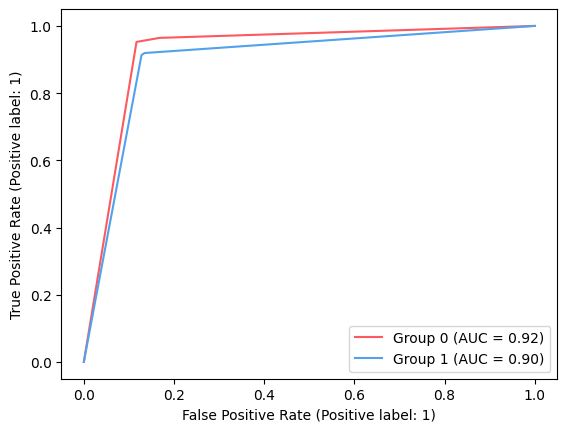

In [40]:
ax_roc_curve = plt.subplot()
colors = ["#fe595f", "#52a1ec"]

for group in [0, 1]:
    roc_group = roc_data[roc_data["group"] == group]
    label = f"Group {group}"

    RocCurveDisplay.from_predictions(
        roc_group["label"],
        roc_group["mitigated_proba"],
        name=label,
        ax=ax_roc_curve,
        color=colors[group],
    )